## This Notebook Contains The Models

In [1]:
import pandas as pd
import numpy as np

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, balanced_accuracy_score, roc_auc_score
from sklearn.datasets import load_breast_cancer, load_iris, make_moons, make_circles, make_classification
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from category_encoders import WOEEncoder
from category_encoders import TargetEncoder, LeaveOneOutEncoder, JamesSteinEncoder, MEstimateEncoder
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import MinMaxScaler, KBinsDiscretizer, FunctionTransformer
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB

from matplotlib import pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from mlxtend.classifier import StackingCVClassifier
from sklearn.ensemble import ExtraTreesClassifier

import xgboost
from xgboost import XGBClassifier

import lightgbm
from lightgbm import LGBMClassifier

from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import make_union
from mlxtend.feature_selection import ColumnSelector

from sklearn.impute import SimpleImputer

import warnings
warnings.filterwarnings("ignore")

from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

import gc; gc.enable()

from dataclean import clean_data

### Read CSV's for Training Data, new tweets and new users

In [2]:
df_tweets = pd.read_csv('debate9tweets.csv')
df_users = pd.read_csv('debate9user20k.csv')
df_train = pd.read_csv('train.csv')

### Clean test data

In [3]:
df_test = clean_data(df_users, df_tweets)

In [4]:
df_train.target.value_counts()

1    4448
0    2891
Name: target, dtype: int64

In [5]:
# def stringify(X):
#     data = pd.DataFrame(X)
#     for c in data.columns.tolist():
#         data[c] = data[c].astype(str)
#     return data.values
    
# objectify = FunctionTransformer(func=stringify, check_inverse=False, validate=False)

# binner = KBinsDiscretizer(n_bins=15, encode='ordinal', strategy='quantile')

### Set used cols, and parameters to test model

In [6]:
target = 'target'
used_cols = [c for c in df_train.columns.tolist() if c not in ['Unnamed: 0.1', 'favorite_min', 'retweet_min', 'Unnamed: 0', target, 'user_id' , 'created_at', 'lang', 'updated', 'id', 'time_zone', 'location', 'profile_use_background_image', 'profile_background_tile', 'utc_offset', 'description', 'crawled_at']]
# used_cols = [c for c in df.columns.tolist() if c not in ['favorite_max', 'favorite_min', 'retweet_min', 'statuses_count', 'followers_count', 'friends_count', 'favourites_count', 'listed_count', 'url', 'geo_enabled', 'default_profile', 'profile_banner_url', 'profile_sidebar_fill_color', 'profile_background_image_url_https','profile_text_color','profile_sidebar_border_color','profile_sidebar_fill_color ','profile_background_image_url','profile_background_color','profile_link_color', 'source_mode', 'Unnamed: 0', target, 'user_id' , 'created_at', 'lang', 'updated', 'id', 'time_zone', 'location', 'profile_use_background_image', 'profile_background_tile', 'utc_offset', 'description', 'crawled_at']]

X, y = df_train[used_cols], df_train[target]

#TRAIN TEST SPLIT
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=42)

In [7]:
cont_cols = [c for c in used_cols if c not in ['source_mode']]

cat_select = ColumnSelector(['source_mode'])
encoder = TargetEncoder()

cont_select = ColumnSelector(cont_cols)

cat_pipe = make_pipeline(cat_select, encoder)
cont_pipe = make_pipeline(cont_select)

### Train Logistic Regression Model 

TRAIN accuracy: 0.9885146972941405
TEST accuracy: 0.9845594913714805


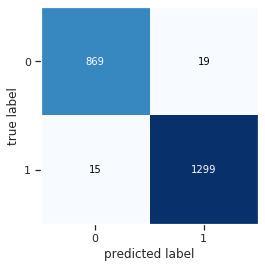

In [8]:
drop_const = VarianceThreshold()
scaler = MinMaxScaler()
imputer = SimpleImputer()

lr = LogisticRegression(class_weight = 'balanced', solver = 'lbfgs', random_state=42)

# pipe = make_pipeline(make_union(cat_pipe, ColumnSelector(cont_cols)), binner, drop_const, scaler, lr)
pipe = make_pipeline(make_union(cat_pipe, ColumnSelector(cont_cols)), imputer, drop_const, scaler, lr)
pipe.fit(X_train, y_train)

# make predictions on training set
y_guess = pipe.predict(X_train)

# make predictions on hold-out set
y_score = pipe.predict(X_test)

#ranked_predictions = predictions.rank(pct=True, method="first")
print("TRAIN accuracy:",accuracy_score(y_train, y_guess))
print("TEST accuracy:",accuracy_score(y_test, y_score))

cm = confusion_matrix(y_test, y_score)
plot_confusion_matrix(cm)
plt.show()

### Run Model on Test Set

In [9]:
X_TRY = df_test[used_cols]

In [10]:
x = (pipe.predict_proba(X_TRY)[:,1] > .15).astype(np.int).tolist()
# pipe.predict(X_TRY)

In [11]:
print('bot: '+ str(x.count(1)))
print('real: '+ str(x.count(0)))

bot: 36
real: 16992


In [12]:
df_test['bot'] = x

In [13]:
df_to_Csv = df_test[df_test.bot  == 0].user_id.reset_index()

### These are the accounts my model predicts as bots

In [14]:
df_to_Csv.head()

,index,user_id
0,0,765
1,1,3839
2,2,7578
3,3,10707
4,4,12916


### Export to Verify 

In [18]:
# df_to_Csv.to_csv('NOTBOTS.csv', index = False) #EXPORT TO CSV